## 머신러닝 알고리즘 적용 _ 심화
    - 데이터 : 사용자 데이터 + 상품 데이터(과거 상품 구매 이력)
    - 신규 모델 : RandomForest, ExtraTrees, BaggingClassifier, (XGBoost)
    - 업데이트된 데이터 + 기존 모델(DT, LR) 평가척도 
    - 업데이트된 데이터 + 신규 모델 평가척도
    - [+2] 피쳐 엔지니어링
    - [+2] 매개변수 조정
    - 캐글 제출 
    - 머신러닝 파이프라인 흐름도 기록

In [1]:
import pandas as pd
import numpy as np
import pickle
import time
import operator
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, f1_score, accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# 신규 데이터 로딩

trn = pd.read_csv('../input/train_append_lb_lag.csv').fillna(0)
target = pd.DataFrame(pickle.load(open('../input/target.pkl','rb')), columns=['target'])
tst = pd.read_csv('../input/test_append_lb_lag.csv').fillna(0)
print(trn.shape, target.shape, tst.shape)

(45619, 246) (45619, 1) (929615, 246)


In [3]:
trn.head()

,age,antiguedad,canal_entrada,cod_prov,conyuemp,fecha_alta,ind_actividad_cliente,ind_empleado,ind_nuevo,indext,...,indrel_lag_fiv,indrel_1mes_lag_fiv,indresi_lag_fiv,nomprov_lag_fiv,pais_residencia_lag_fiv,renta_lag_fiv,segmento_lag_fiv,sexo_lag_fiv,tiprel_1mes_lag_fiv,ult_fec_cli_1t_lag_fiv
0,28,34,150,20,2,1012,1,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,28,34,150,20,2,1012,1,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,37,34,122,20,2,1012,1,3,0,0,...,0.0,0.0,1.0,30.0,36.0,107894.0,1.0,1.0,0.0,-153.0
3,37,34,122,20,2,1012,1,3,0,0,...,0.0,0.0,1.0,30.0,36.0,107894.0,1.0,1.0,0.0,-153.0
4,40,34,122,20,2,1012,1,3,0,0,...,0.0,0.0,1.0,30.0,36.0,93847.0,1.0,0.0,0.0,-153.0


In [4]:
trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45619 entries, 0 to 45618
Columns: 246 entries, age to ult_fec_cli_1t_lag_fiv
dtypes: float64(225), int64(21)
memory usage: 85.6 MB


In [5]:
# 신규 데이터 설명
for col in trn.columns:
    print(col)

age
antiguedad
canal_entrada
cod_prov
conyuemp
fecha_alta
ind_actividad_cliente
ind_empleado
ind_nuevo
indext
indfall
indrel
indrel_1mes
indresi
nomprov
pais_residencia
renta
segmento
sexo
tiprel_1mes
ult_fec_cli_1t
age_lag_one
antiguedad_lag_one
canal_entrada_lag_one
cod_prov_lag_one
conyuemp_lag_one
fecha_alta_lag_one
ind_actividad_cliente_lag_one
ind_ahor_fin_ult1_lag_one
ind_aval_fin_ult1_lag_one
ind_cco_fin_ult1_lag_one
ind_cder_fin_ult1_lag_one
ind_cno_fin_ult1_lag_one
ind_ctju_fin_ult1_lag_one
ind_ctma_fin_ult1_lag_one
ind_ctop_fin_ult1_lag_one
ind_ctpp_fin_ult1_lag_one
ind_deco_fin_ult1_lag_one
ind_dela_fin_ult1_lag_one
ind_deme_fin_ult1_lag_one
ind_ecue_fin_ult1_lag_one
ind_empleado_lag_one
ind_fond_fin_ult1_lag_one
ind_hip_fin_ult1_lag_one
ind_nom_pens_ult1_lag_one
ind_nomina_ult1_lag_one
ind_nuevo_lag_one
ind_plan_fin_ult1_lag_one
ind_pres_fin_ult1_lag_one
ind_reca_fin_ult1_lag_one
ind_recibo_ult1_lag_one
ind_tjcr_fin_ult1_lag_one
ind_valo_fin_ult1_lag_one
ind_viv_fin_ult1_l

In [6]:
# 훈련 데이터와 테스트 데이터 동일 여부 확인
trn.columns == tst.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [7]:
# 빈도가 낮은 타겟은 사전에 제거 (이유: 교차 검증에 활용할 수 없음 + 너무 빈도가 낮아 무의미함)
rem_targets = [2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 23]  # 18 classes
trn = trn[target['target'].isin(rem_targets)]
target = target[target['target'].isin(rem_targets)]
target = LabelEncoder().fit_transform(target)

for t in np.unique(target):
    print(t, sum(target==t))

/Users/yohan/anaconda/lib/python3.5/site-packages/sklearn/preprocessing/label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0 9452
1 1934
2 55
3 349
4 222
5 154
6 503
7 33
8 1085
9 1219
10 246
11 21
12 2942
13 4733
14 159
15 5151
16 8218
17 9119


## 평가용 함수 정의

In [8]:
def evaluate(x, y, model):
    trn_scores = dict(); vld_scores = dict()
    sss = StratifiedShuffleSplit(n_splits=3, test_size=0.1, random_state=777)
    for t_ind, v_ind in sss.split(x,y):
        # split data
        x_trn, x_vld = x.iloc[t_ind], x.iloc[v_ind]
        y_trn, y_vld = y[t_ind], y[v_ind]

        # fit model
        model.fit(x_trn, y_trn)
        
        # eval _ trn        
        preds = model.predict_proba(x_trn)

        log_scores = trn_scores.get('log loss', [])
        log_scores.append(log_loss(y_trn, preds))
        trn_scores['log loss'] = log_scores

        # eval _ vld
        preds = model.predict_proba(x_vld)

        log_scores = vld_scores.get('log loss', [])
        log_scores.append(log_loss(y_vld, preds))
        vld_scores['log loss'] = log_scores
    return trn_scores, vld_scores

def print_scores(trn_scores, vld_scores):
    prefix = '        '
    cols = ['log loss']
    print('='*50)
    print('TRAIN EVAL')
    for col in cols:  
        print('-'*50)
        print('# {}'.format(col))
        print('# {} Mean : {}'.format(prefix, np.mean(trn_scores[col])))
        print('# {} Raw  : {}'.format(prefix, trn_scores[col]))

    print('='*50)
    print('VALID EVAL')
    for col in cols:
        print('-'*50)
        print('# {}'.format(col))
        print('# {} Mean : {}'.format(prefix, np.mean(vld_scores[col])))
        print('# {} Raw  : {}'.format(prefix, vld_scores[col]))

def print_time(end, start):
    print('='*50)
    elapsed = end - start
    print('{} secs'.format(round(elapsed)))
    
def fit_and_eval(trn, target, model):
    trn_scores, vld_scores = evaluate(trn,target,model)
    print_scores(trn_scores, vld_scores)
    print_time(time.time(), st)    

## 모델 학습 및 평가
    - 모델 종류
        - Decision Tree : 트리 기반 모델
        - Logistic Regression : 선형 모델
        - RandomForest, ExtraTrees : 트리 기반 앙상블 모델
        - BaggingClassifier : 앙상블 모델
        - (XGBoost) : 트리 기반 앙상블 모델
        
        실제 적용된 모델은 RandomForest
        
    - 훈련/검증 데이터 기반 평가 척도
        - Log Loss  
        
    - 검증 데이터 Log Loss 목표 수치 = 1.1

### 3회차 모델

In [9]:
st = time.time()
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=4, n_estimators = 5, n_jobs=-1, random_state=777) # Max_depth를 낮춰야 복잡성을 줄이는 것. 
fit_and_eval(trn, target, rf_model)
# 5 sec

TRAIN EVAL
--------------------------------------------------
# log loss
#          Mean : 1.6727671183674755
#          Raw  : [1.6928505893960248, 1.6968369488032773, 1.6286138169031243]
VALID EVAL
--------------------------------------------------
# log loss
#          Mean : 1.6786285123443572
#          Raw  : [1.700122286321079, 1.7020074015208713, 1.6337558491911217]
4 secs


## 모델 매개변수 및 주요 변수 시각화 (1)
    - RandomForest 전용

In [11]:
# Utility

def observe_model_tree(trn, model):
    print('='*50)
    print(model)
    
    print('='*50)
    print('# Feature Importance')
    print(model.feature_importances_)
    
    print('-'*50)
    print('# Mapped to Column Name')
    prefix = '    '
    feature_importance = dict()
    for i, f_imp in enumerate(model.feature_importances_):
        print('{} {} \t {}'.format(prefix, round(f_imp,5), trn.columns[i]))
        feature_importance[trn.columns[i]] = f_imp

    print('-'*50)
    print('# Sorted Feature Importance')
    feature_importance_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
    for item in feature_importance_sorted:
        print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))
    
    return feature_importance_sorted

def plot_fimp(fimp):
    x = []; y = []
    for item in fimp:
        x.append(item[0])
        y.append(item[1])

    f, ax = plt.subplots(figsize=(20, 15))
    sns.barplot(x,y,alpha=0.5)
    ax.set_title('Feature Importance for Model : Decision Tree')
    ax.set(xlabel='Column Name', ylabel='Feature Importance')

In [12]:
# 모델 상세 보기
rf_fimp = observe_model_tree(trn, rf_model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=-1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)
# Feature Importance
[  4.81574400e-02   1.25841800e-02   8.38298932e-04   4.56827578e-05
   0.00000000e+00   0.00000000e+00   3.73305010e-04   0.00000000e+00
   1.57210941e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.59322425e-03   1.15166554e-05   1.57599828e-03
   0.00000000e+00   0.00000000e+00   1.03366942e-03   8.35050868e-02
   0.00000000e+00   0.00000000e+00   2.57371739e-06   5.57176878e-02
   0.00000000e+00   0.00000000e+00   6.93635595e-02   0.00000000e+00
   1.13348898e-02   0.00000000e+00   0.00000000e

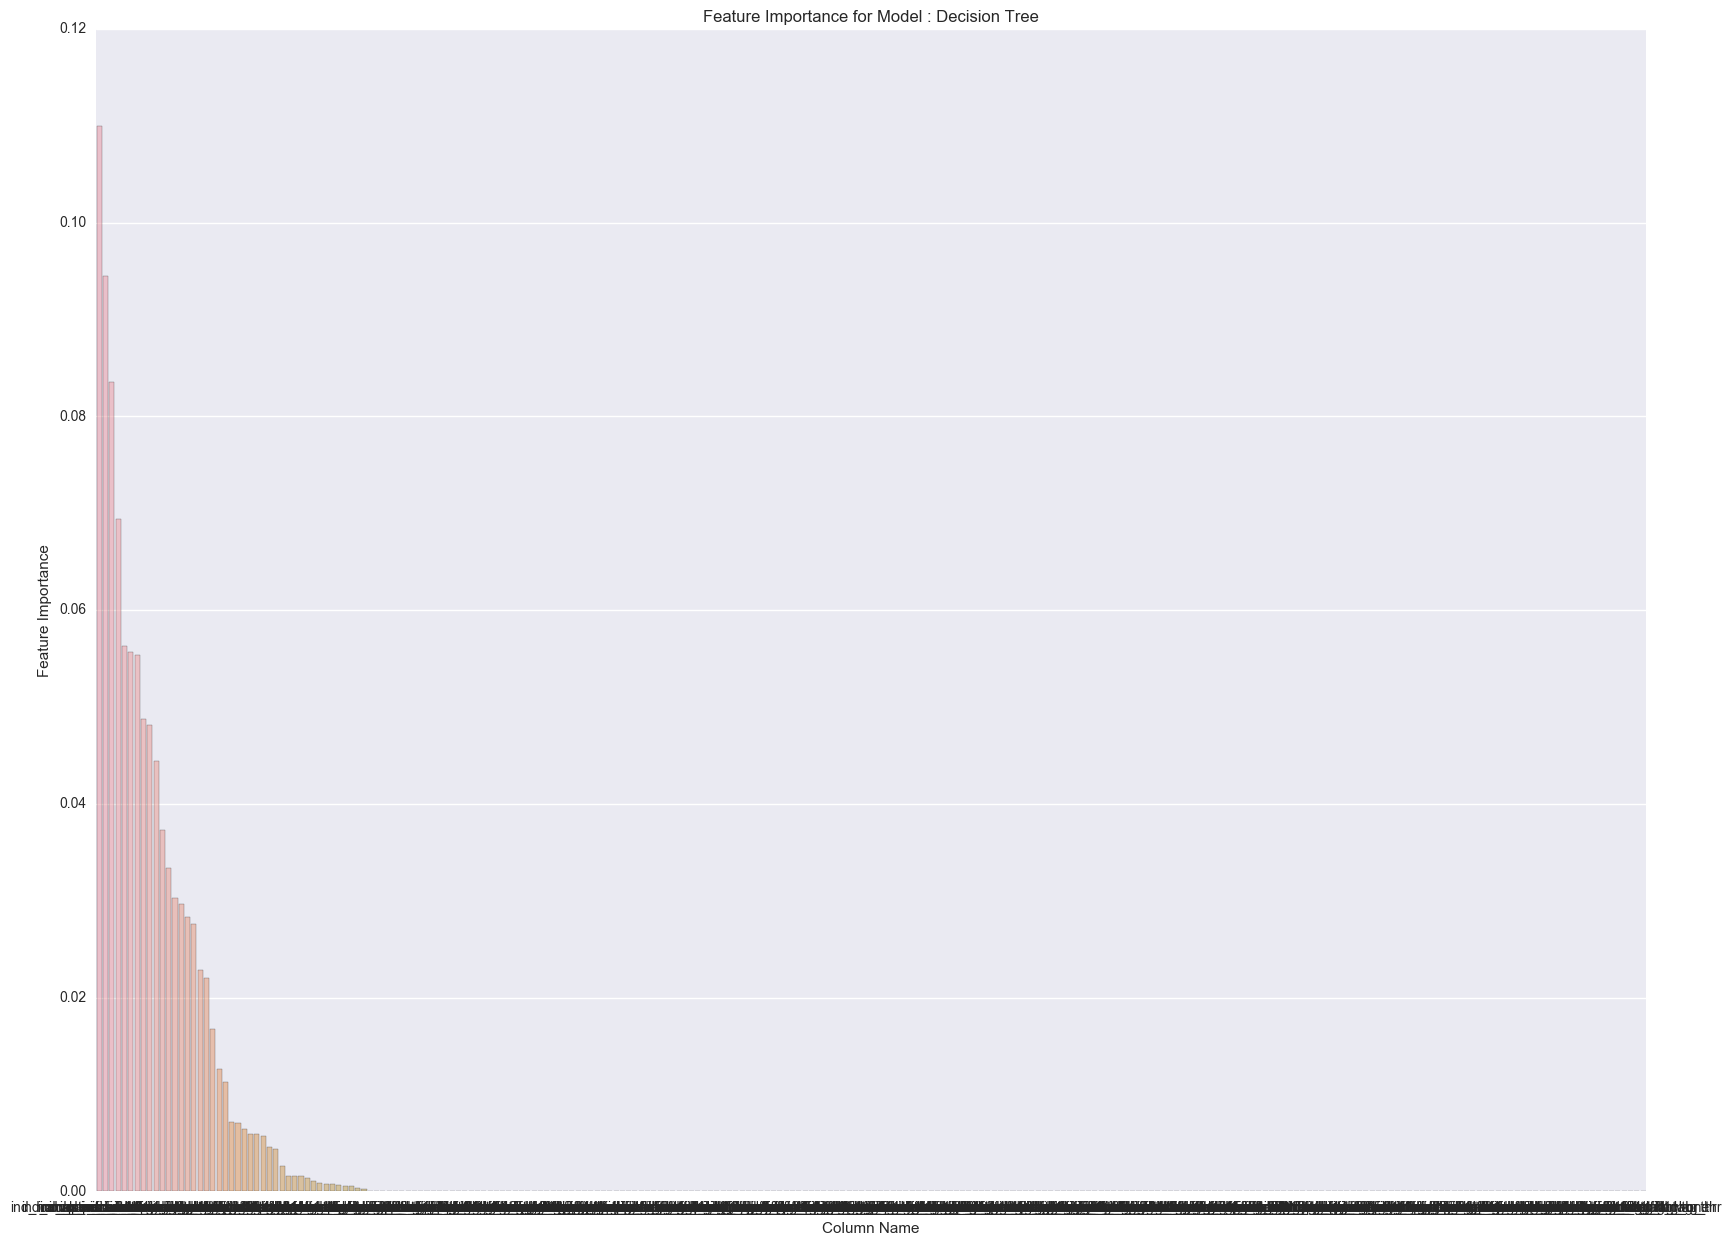

In [13]:
# 주요 변수 시각화
plot_fimp(rf_fimp)

## 피쳐 엔지니어링 (데이터 최적화) [+2]
    - 직접 새로운 변수를 추가 혹은 기존 변수를 삭제하여서 최적의 변수세트 생성해보기
    - 주의: 훈련 데이터에 수행한 변수 변환은 테스트 데이터에도 동일하게 수행해야함
    - 힌트: 금융 상품에 대한 새로운 정보를 넣는 것

In [ ]:
# 입력 : trn, target, tst
# 출력 : new trn, new tst, same target

In [14]:
cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
        'ind_cder_fin_ult1', 'ind_cno_fin_ult1',  'ind_ctju_fin_ult1',
        'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
        'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
        'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
        'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
        'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
        'ind_nomina_ult1',   'ind_nom_pens_ult1', 'ind_recibo_ult1']

print(trn.shape, tst.shape)

# 타겟별 누적 합
lags = ['_lag_one','_lag_two','_lag_thr','_lag_fou','_lag_fiv']
for col in cols:
    trn[col+'_sum'] = trn[[col+lag for lag in lags]].sum(axis=1)
    tst[col+'_sum'] = tst[[col+lag for lag in lags]].sum(axis=1)
    
# 월별 누적 합
for lag in lags:
    trn['sum'+lag] = trn[[col+lag for col in cols]].sum(axis=1)
    tst['sum'+lag] = tst[[col+lag for col in cols]].sum(axis=1)
    
print(trn.shape, tst.shape)

(45595, 246) (929615, 246)
(45595, 275) (929615, 275)


In [15]:
rf_fimp = observe_model_tree(trn, rf_model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=-1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)
# Feature Importance
[  4.81574400e-02   1.25841800e-02   8.38298932e-04   4.56827578e-05
   0.00000000e+00   0.00000000e+00   3.73305010e-04   0.00000000e+00
   1.57210941e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   2.59322425e-03   1.15166554e-05   1.57599828e-03
   0.00000000e+00   0.00000000e+00   1.03366942e-03   8.35050868e-02
   0.00000000e+00   0.00000000e+00   2.57371739e-06   5.57176878e-02
   0.00000000e+00   0.00000000e+00   6.93635595e-02   0.00000000e+00
   1.13348898e-02   0.00000000e+00   0.00000000e

In [16]:
st = time.time()
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=6, max_features = .60, n_estimators = 12, n_jobs=-1, random_state=777) 
fit_and_eval(trn, target, rf_model)

TRAIN EVAL
--------------------------------------------------
# log loss
#          Mean : 1.1443627382524058
#          Raw  : [1.1428988156094262, 1.1407447582246364, 1.1494446409231549]
VALID EVAL
--------------------------------------------------
# log loss
#          Mean : 1.1639815913118048
#          Raw  : [1.1654846958899234, 1.1656387434928024, 1.1608213345526892]
10 secs


## 매개변수 최적화 (모델 최적화) [+1]
    - 사용하는 모델의 매개변수를 직접 정의하여 최적의 매개변수 찾아내기
    - 참고: scikit learn 홈페이지를 통해 모델별 매개변수 확인 가능
    - 힌트: trn/vld logloss 를 비교하여, 모델의 복잡도를 조정하기

In [ ]:
# 입력 : none
# 출력: model instance

## 캐글에 직접 결과물 제출하기
    - MAP@7 평가척도를 기반 (https://www.kaggle.com/c/santander-product-recommendation/details/evaluation)
    - 유저당 상위 7개의 제품을 추천해야함

In [17]:
# 최종 모델 정의하기
model = RandomForestClassifier(max_depth=6, max_features = .60, n_estimators = 12, n_jobs=-1, random_state=777)

In [18]:
# 최종 모델 정의하기
model = RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=777)

In [19]:
from datetime import datetime
import os

print('='*50)
print('# Test shape : {}'.format(tst.shape))

model.fit(trn,target)

preds = model.predict_proba(tst)
preds = np.fliplr(np.argsort(preds, axis=1))

# Test shape : (929615, 275)


In [20]:
cols = ['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
        'ind_cder_fin_ult1', 'ind_cno_fin_ult1',  'ind_ctju_fin_ult1',
        'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
        'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
        'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
        'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
        'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
        'ind_nomina_ult1',   'ind_nom_pens_ult1', 'ind_recibo_ult1']
target_cols = [cols[i] for i, col in enumerate(cols) if i in rem_targets]

In [21]:
final_preds = []
for pred in preds:
    top_products = []
    for i, product in enumerate(pred):
        top_products.append(target_cols[product])
        if i == 6:
            break
    final_preds.append(' '.join(top_products))

temp = pd.read_csv('../input/test_clean.csv')
test_id = temp['ncodpers']
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})
file_name = datetime.now().strftime("result_%Y%m%d%H%M%S") + '.csv'
out_df.to_csv(os.path.join('../output',file_name), index=False)

결과물 출력은 https://www.kaggle.com/c/santander-product-recommendation/submissions/attach

## 나만의 머신러닝 파이프라인 흐름도(Flow Chart) 기록하기

- 원천 데이터
    - .

- 전처리
    - .

- 피쳐 엔지니어링 이전 데이터 dimension
    - .

- 피쳐 엔지니어링 
    - .

- 피쳐 엔지니어링 이후 데이터 dimension
    - .

- 모델 튜닝 
    - .

- 검증 결과 
    - .

- 실제 결과 
    - .

예시

- 원천 데이터 
    - Kaggle 경진대회 데이터 train_ver2.csv, test_ver2.csv (Link: https://www.kaggle.com/c/santander-product-recommendation/data)


- 전처리 
    - 결측값을 .fillna 함수를 통해 0으로 대체. (기존 데이터에 0이 존재할 경우 -1로 대체)


- 피쳐 엔지니어링 이전 데이터 dimension:
    - trn : (45619, 246)
    - target : (45619, 1) [18 classes]
    - tst : (929615, 246)


- 피쳐 엔지니어링
    - age_log : log(age + 1)
    - ind..._lag_one : 5월 사용자별 금융상품 보유현황
    - ind..._lag_two : 4월 사용자별 금융상품 보유현황
    - ind..._lag_thr : 3월 사용자별 금융상품 보유현황


- 피쳐 엔지니어링 이후 데이터 dimension:
    - trn : (45619, 250)
    - target : (45619, 1) [18 classes]
    - tst : (929615, 250)


- 모델 튜닝 
    - RandomForest : max_depth = 20 로 복잡도 조정


- 검증 결과 
    - trn logloss : 1.18
    - vld logloss : 1.28


- 실제 결과 
    - Public Leaderboard : 0.025984


## Appendix
    - RandomForest vs ExtraTrees 의 차이란?
        - P. Geurts, D. Ernst., and L. Wehenkel, “Extremely randomized trees”, Machine Learning, 63(1), 3-42, 2006
        - 1) ET의 경우, 변수 샘플링을 boostrap 샘플이 아닌 전체 데이터에서 취한다.
        - 2) ET의 경우, 샘플내 분포에 상관없이 완전한 임의 샘플링으로 데이터 샘플을 취한다.